## 決定木モデルの比較
## (sklearnライブラリ vs 手動)
---

### 1. エントロピー（不純度）の定義

あるラベル集合 \( S \) のエントロピーは、

$$
H(S) = - \sum_{c=1}^{C} p_c \log_2 p_c
$$


 C  はクラス数、  
$ p_c $ はクラス Cの割合（頻度）

---

### 2. 情報利得

ある特徴量 $X_j$を使って閾値 t で分割し、  
左右の部分集合を $ S_{\text{left}} $, $ S_{\text{right}} $ とすると、

$$
IG(S, X_j, t) = H(S) - \frac{|S_{\text{left}}|}{|S|} H(S_{\text{left}}) - \frac{|S_{\text{right}}|}{|S|} H(S_{\text{right}})
$$

- |S| は集合 S のサイズ（サンプル数）

---

### 3. 最適分割の選択

全ての特徴量 j と閾値 t について情報利得を計算し、

$$
(j^*, t^*) = \arg\max_{j, t} IG(S, X_j, t)
$$

最も情報利得が大きい分割を決定し、その特徴量と閾値でノードを分割する


In [2]:
#ライブラリのインポート

import numpy as np
from collections import Counter
import time
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


In [ ]:
# データの準備 

wine = load_wine()
X = wine.data
y = wine.target
print(X.shape)
pca = PCA(n_components=2) #主成分分析で2次元に変換
X_pca = pca.fit_transform(X)
print(X_pca)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)


[[1.423e+01 1.710e+00 2.430e+00 ... 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 ... 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 ... 1.030e+00 3.170e+00 1.185e+03]
 ...
 [1.327e+01 4.280e+00 2.260e+00 ... 5.900e-01 1.560e+00 8.350e+02]
 [1.317e+01 2.590e+00 2.370e+00 ... 6.000e-01 1.620e+00 8.400e+02]
 [1.413e+01 4.100e+00 2.740e+00 ... 6.100e-01 1.600e+00 5.600e+02]]


In [ ]:
# 手動決定木の学習
def entropy(y): # y = [0, 1, 0, 2] count(i)は非効率
    counts = np.bincount(y) #[2,1,1]
    ps = counts / len(y) # [0.5, 0.25, 0.25]
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

def info_gain(y, y_left, y_right):
    h = entropy(y)
    h_left = entropy(y_left)
    h_right = entropy(y_right)
    return h - (len(y_left) / len(y)) * h_left - (len(y_right) / len(y)) * h_right

def best_split(X, y):
    best_feature, best_thresh, best_gain = None, None, -1
    n_samples, n_features = X.shape

    for feature in range(n_features):
        thresholds = np.unique(X[:, feature]) #X[:, 0] = [5.1, 4.9, 5.8, 5.1, 4.9]→ array([4.9, 5.1, 5.8])
        for thresh in thresholds:
            left_idx = X[:, feature] <= thresh #[ True, False, False, False, False ]
            right_idx = X[:, feature] > thresh
            if sum(left_idx) == 0 or sum(right_idx) == 0:
                continue
            gain = info_gain(y, y[left_idx], y[right_idx])
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_thresh = thresh

    return best_feature, best_thresh, best_gain

class Node:
    def __init__(self, depth=0, max_depth=3):
        self.depth = depth
        self.max_depth = max_depth
        self.feature = None #このノードで分割に使う特徴量のインデックス
        self.threshold = None 
        self.left = None
        self.right = None
        self.label = None #このノードが葉ノードである場合の分類ラベル

    def fit(self, X, y):#y = [0, 1, 1, 2, 1, 0]
        if self.depth == self.max_depth or len(set(y)) == 1:
            self.label = Counter(y).most_common(1)[0][0]#[(1, 3)] (1, 3) 1
            return

        feature, thresh, gain = best_split(X, y)
        if gain == 0 or feature is None:
            self.label = Counter(y).most_common(1)[0][0]
            return

        self.feature = feature
        self.threshold = thresh

        left_idx = X[:, feature] <= thresh #left_idx = [True, False, True, False, True] 
        right_idx = X[:, feature] > thresh

        self.left = Node(depth=self.depth + 1, max_depth=self.max_depth)
        self.left.fit(X[left_idx], y[left_idx])

        self.right = Node(depth=self.depth + 1, max_depth=self.max_depth)
        self.right.fit(X[right_idx], y[right_idx])

    def predict_single(self, x):
        if self.label is not None:
            return self.label
        if x[self.feature] <= self.threshold:
            return self.left.predict_single(x)
        else:
            return self.right.predict_single(x)

    def predict(self, X):
        return np.array([self.predict_single(x) for x in X])

start_train_manual = time.perf_counter()
root = Node(max_depth=3)
root.fit(X_train, y_train)
end_train_manual = time.perf_counter()

y_pred_manual = root.predict(X_test)
acc_manual = accuracy_score(y_test, y_pred_manual)
print(f"[Manual] 学習時間: {(end_train_manual - start_train_manual)*1000:.3f} ms, 精度: {acc_manual:.3f}")


[Manual] 学習時間: 167.487 ms, 精度: 0.815


In [4]:
# sklearn 決定木の学習

start_train_lib = time.perf_counter()
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)
end_train_lib = time.perf_counter()

y_pred_lib = clf.predict(X_test)
acc_lib = accuracy_score(y_test, y_pred_lib)
print(f"[scikit-learn] 学習時間: {(end_train_lib - start_train_lib)*1000:.3f} ms, 精度: {acc_lib:.3f}")


[scikit-learn] 学習時間: 27.672 ms, 精度: 0.815


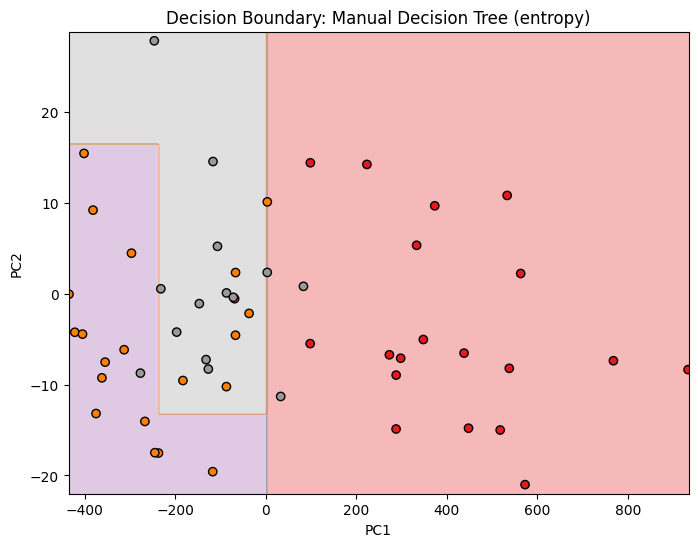

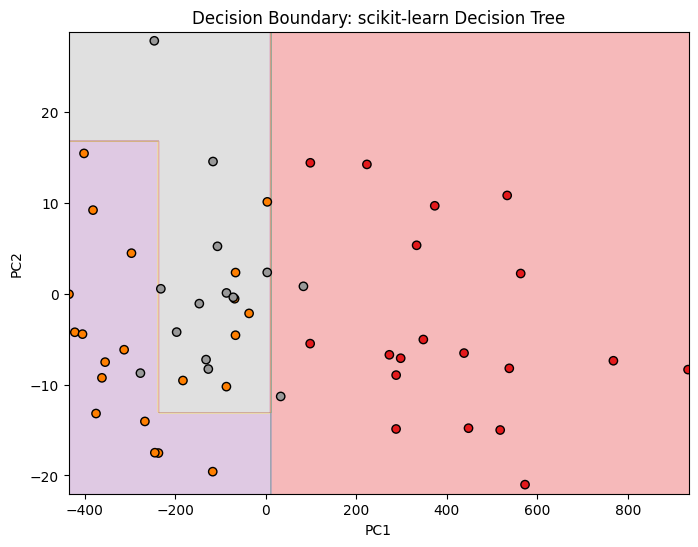

In [ ]:
#それぞれの境界線描写
def plot_decision_boundary(X, y, predict_func, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), #グリットつくるmesh,minからmaxを300等分配
                         np.linspace(y_min, y_max, 300)) #xx = (300, 300)
    Z = predict_func(np.c_[xx.ravel(), yy.ravel()]) #ravelで1次元の長さ90000の配列に変換して、
    Z = Z.reshape(xx.shape)                         #np.c_で(90000, 2) の2列配列[[x0, y0], [x1, y0], ...]

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1) #「色で塗りつぶした等高線図」を描く関数。Zは座標に対応する数値の2D配列（高さとか予測値）
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Set1)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

plot_decision_boundary(X_test, y_test, root.predict, "Decision Boundary: Manual Decision Tree (entropy)")
plot_decision_boundary(X_test, y_test, clf.predict, "Decision Boundary: scikit-learn Decision Tree")

""" 
xx[[0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]]
"""